In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from tqdm import tqdm
from sudoku import Sudoku as PySudoku

In [2]:
def sudoku_part1(img):
    '''Integrated from Part 1.'''
    # Denoise.
    denoisedImg = cv2.medianBlur(img, 5)
    # Threashold.
    threshedImg = cv2.adaptiveThreshold(denoisedImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    threshedImg = cv2.medianBlur(threshedImg, 7)
    # Find contour.
    contours, _ = cv2.findContours(threshedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))[::-1]
    puzzleContour = contours[0]
    # Find corners.
    perimeterContour = cv2.arcLength(puzzleContour, True)
    for i in range(0, 100):
        corners = cv2.approxPolyDP(puzzleContour, i / 100.0 * perimeterContour, True)
        if len(corners) == 4:
            break
    corners = np.array(corners).squeeze()
    # Get corners mapping.
    edgeLengths = [cv2.arcLength(np.array([corners[i], corners[j]]), False) for (i, j) in [(0, 1), (1, 2), (2, 3), (3, 1)]]
    height = width = int(max(edgeLengths))
    deskewedPoints = [(0, 0), (width - 1, 0), (width - 1, height - 1), (0, height - 1)] # Anti-clockwise.
    deskewedPoints = np.array(deskewedPoints)
    def getSkewedPoints(corners):
        '''Anti-clockwise.'''
        sum_ = corners.sum(axis=1)
        diff = -np.diff(corners, axis=1)
        br = corners[np.argmax(sum_)]
        tl = corners[np.argmin(sum_)]
        bl = corners[np.argmin(diff)]
        tr = corners[np.argmax(diff)]

        return np.array([tl, tr, br, bl])

    skewedPoints = getSkewedPoints(corners)
    # Deskew.
    transform = cv2.getPerspectiveTransform(skewedPoints.astype(np.float32), deskewedPoints.astype(np.float32))
    deskewedImg = cv2.warpPerspective(denoisedImg, transform, (width, height))

    return deskewedImg

def sudoku_part2(deskewedImg):
    '''Integrated from Part 2.'''
    # Remove the grid.
    threshedImg = cv2.adaptiveThreshold(deskewedImg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    def getSeedPoint(img, th=0.9):
        h, w = img.shape
        r = None
        for i in range(h):
            r = h - i - 1
            if np.sum(img[r, :]) <= (1.0 - th) * w * 255:
                break
        for c in range(w):
            if img[r, c] == 0:
                return c, r
        return None, None

    SeedPoint = getSeedPoint(threshedImg)
    h, w = threshedImg.shape
    gridImg = cv2.cvtColor(threshedImg, cv2.COLOR_GRAY2BGR)
    gridMask = np.zeros((h + 2, w + 2), dtype=np.uint8)
    _, gridMarkedImg, gridMask, _ = cv2.floodFill(gridImg, gridMask, SeedPoint, (255, 0, 0))
    gridMask = gridMask[1:-1, 1:-1]
    gridMask = cv2.dilate(gridMask, np.ones((3, 3)))
    noGridImg = deskewedImg.copy()
    noGridImg[gridMask != 0] = 255
    # Crop into cells.
    h, w = noGridImg.shape
    cellH, cellW = h // 9, w // 9
    centerCropH, centerCropW = 64, 64
        
    def cropCell(img, row, col, cellH, cellW, centerCropH, centerCropW):
        assert row < 9 and col < 9 and row >= 0 and col >= 0

        r0 = row * cellH; c0 = col * cellW
        cell = np.array(img[r0 : r0 + cellH, c0 : c0 + cellW])
        leftTopRow = (cellH - centerCropH) // 2
        leftTopCol = (cellW - centerCropW) // 2
        
        cell = cell[leftTopRow : leftTopRow + centerCropH, leftTopCol : leftTopCol + centerCropW]

        return cell

    cellImgs = []
    for r in range(9):
        for c in range(9):
            cellImgs.append(cropCell(noGridImg, r, c, cellH, cellW, centerCropH, centerCropW))
    cellImgs = np.array(cellImgs).reshape(9, 9, centerCropH, centerCropW)
    # Count non-zeros.
    nonZeros = []
    threshedCells = []
    for r in range(9):
        for c in range(9):
            cell = np.array(cellImgs[r, c, ...])
            cell[cell > (255 // 2)] = 255
            cell = cv2.adaptiveThreshold(cell, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 0)
            threshedCells.append(cell)
            nonZeros.append(cv2.countNonZero(cell))
    threshedCells = np.array(threshedCells).reshape(9, 9, centerCropH, centerCropW)
    nonZeros = np.array(nonZeros).reshape(9, 9)
    # Identify empty/fill.
    emptyFills = nonZeros.copy()
    emptyFills[emptyFills < 125] = 0
    emptyFills[emptyFills > 0] = 1
    
    return cellImgs, emptyFills

In [3]:
DigitsDir = './data/digits_arial_calibri'
Digits = []
Labels = []
for file in os.listdir(DigitsDir):
    path = os.path.join(DigitsDir, file)
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    Digits.append(img)
    Labels.append(int(file[0]))
Digits = np.array(Digits)
Labels = np.array(Labels)
DigitH, DigitW = Digits[0].shape

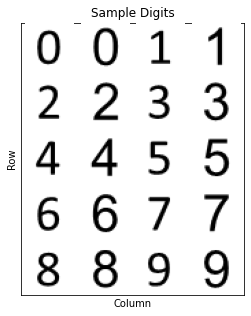

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [4]:
fig = plt.figure(figsize=(4, 5))
plt.title('Sample Digits'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.1)

for idx, (ax, im) in enumerate(zip(grid, Digits)):
    ax.imshow(im, cmap='gray'); ax.axis('off')
    
plt.show()
Labels

In [5]:
# Resize into (20, 20).
SmDigitH, SmDigitW = 20, 20
SmDigits = []
for i in range(len(Digits)):
    digit = Digits[i]
    digit = cv2.resize(digit, (SmDigitW, SmDigitH))
    SmDigits.append(np.array(digit))
SmDigits = np.array(SmDigits)

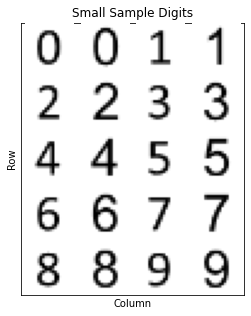

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [6]:
fig = plt.figure(figsize=(4, 5))
plt.title('Small Sample Digits'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(5, 4), axes_pad=0.1)

for idx, (ax, im) in enumerate(zip(grid, SmDigits)):
    ax.imshow(im, cmap='gray'); ax.axis('off')
    
plt.show()
Labels

In [7]:
def createHOG():
    # To avoid variables pollution.
    winSize = (20, 20)
    blockSize = (8, 8)
    blockStride = (4, 4)
    cellSize = (8, 8)
    nbins = 9
    derivAperture = 1
    winSigma = -1
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 0
    nlevels = 64
    signedGradient = 1
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, 
                            winSigma, histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradient)
    
    return hog

hog = createHOG()

In [8]:
referenceHOG = []
for digit in SmDigits:
    vec = hog.compute(digit)
    referenceHOG.append(vec)

referenceHOG = np.array(referenceHOG)
referenceHOG.shape

(20, 144)

In [9]:
def compute_NN(testHOG, referenceHOG):
    def computeDistance(x, y):
        totalDist = ((x - y) ** 2).sum()
        return np.sqrt(totalDist)

    minDist = np.inf - 1
    minIndex = -1
    for i in range(len(referenceHOG)):
        ref = referenceHOG[i]
        dist = computeDistance(testHOG, ref)
        if dist < minDist:
            minDist = dist
            minIndex = i
    
    return minIndex, minDist

In [10]:
SudokuImgPath = './data/sudoku1.jpg'
img = cv2.imread(SudokuImgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
deskewedImg = sudoku_part1(img)
cellImgs, emptyFills = sudoku_part2(deskewedImg)

In [11]:
thAndResizedCellImgs = np.zeros((9, 9, SmDigitH, SmDigitW), dtype=np.uint8)
for r in range(9):
    for c in range(9):
        img = np.array(cellImgs[r, c, ...])
        img = cv2.resize(img, (SmDigitW, SmDigitH))
        if emptyFills[r, c] == 1:
            img[img > 255 // 2] = 255
            img[img < 255] = 0
        else:
            img = 0
        thAndResizedCellImgs[r, c, ...] = img

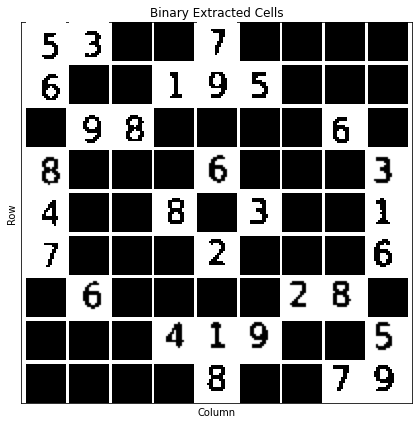

In [12]:
fig = plt.figure(figsize=(7, 7))
plt.title('Binary Extracted Cells'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(9, 9), axes_pad=0.05)

for ax, im in zip(grid, thAndResizedCellImgs.reshape(-1, SmDigitH, SmDigitW)):
    ax.imshow(im, cmap='gray'); ax.axis('off')

plt.show()

In [13]:
def slidingWindowDigitRecog(img, startSize, hogObject, refHOG, refLabels, refH, refW):
    h, w = img.shape
    assert startSize <= h and startSize <= w
    minDist = np.inf - 1
    minIndex = -1
    
    for size in range(startSize, min(h, w) + 1):
        for r in range(h):
            for c in range(w):
                if r + size > h or c + size > w:
                    continue
                patch = np.array(img[r : r + size, c : c + size])
                patch = cv2.resize(patch, (refW, refH))
                _minIndex, _minDist = compute_NN(hogObject.compute(patch), refHOG)
                if _minDist < minDist:
                    minDist = _minDist
                    minIndex = _minIndex
    
    return refLabels[minIndex], minDist

In [14]:
SudokuBoard = np.zeros((9, 9), dtype=np.int32)
SlidingWindowStartSize = 15
for r in range(0, 9):
    for c in range(0, 9):
        if emptyFills[r, c] == 1: # It is filled.
            cellImg = thAndResizedCellImgs[r, c]
            digit, dist = slidingWindowDigitRecog(cellImg, SlidingWindowStartSize, hog, referenceHOG, Labels, SmDigitH, SmDigitW)
            SudokuBoard[r, c] = digit

In [15]:
SudokuBoard

array([[5, 3, 0, 0, 7, 0, 0, 0, 0],
       [6, 0, 0, 1, 9, 5, 0, 0, 0],
       [0, 9, 8, 0, 0, 0, 0, 6, 0],
       [8, 0, 0, 0, 6, 0, 0, 0, 3],
       [4, 0, 0, 8, 0, 3, 0, 0, 1],
       [7, 0, 0, 0, 2, 0, 0, 0, 6],
       [0, 6, 0, 0, 0, 0, 2, 8, 0],
       [0, 0, 0, 4, 1, 9, 0, 0, 5],
       [0, 0, 0, 0, 8, 0, 0, 7, 9]])

In [16]:
textedCells = np.zeros((*cellImgs.shape, 3), dtype=np.uint8) # Colored
CellH, CellW = cellImgs[0, 0].shape
for r in range(0, 9):
    for c in range(0, 9):
        img = cellImgs[r, c, ...]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cellValue = SudokuBoard[r, c]
        img = cv2.putText(img, str(cellValue) if cellValue != 0 else '/', (0, CellH), cv2.FONT_HERSHEY_COMPLEX, 1.25, (255, 0, 0))
        textedCells[r, c, ...] = img

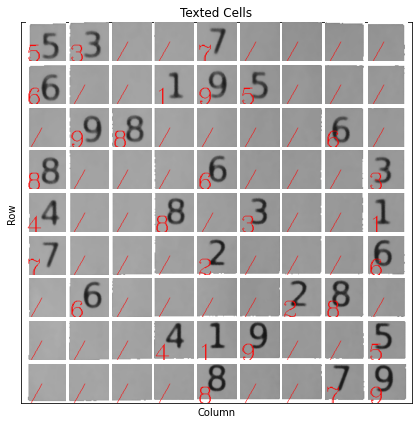

In [17]:
fig = plt.figure(figsize=(7, 7))
plt.title('Texted Cells'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(9, 9), axes_pad=0.05)

for ax, im in zip(grid, textedCells.reshape(-1, CellH, CellW, 3)):
    ax.imshow(im); ax.axis('off')

plt.show()

In [18]:
sudokuObj = PySudoku(3, 3, board=SudokuBoard.tolist())
print(sudokuObj)


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: 0.63
---------------------------
+-------+-------+-------+
| 5 3   |   7   |       |
| 6     | 1 9 5 |       |
|   9 8 |       |   6   |
+-------+-------+-------+
| 8     |   6   |     3 |
| 4     | 8   3 |     1 |
| 7     |   2   |     6 |
+-------+-------+-------+
|   6   |       | 2 8   |
|       | 4 1 9 |     5 |
|       |   8   |   7 9 |
+-------+-------+-------+

        


In [19]:
sudokuObj = sudokuObj.solve()
print(sudokuObj)


---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 5 3 4 | 6 7 8 | 9 1 2 |
| 6 7 2 | 1 9 5 | 3 4 8 |
| 1 9 8 | 3 4 2 | 5 6 7 |
+-------+-------+-------+
| 8 5 9 | 7 6 1 | 4 2 3 |
| 4 2 6 | 8 5 3 | 7 9 1 |
| 7 1 3 | 9 2 4 | 8 5 6 |
+-------+-------+-------+
| 9 6 1 | 5 3 7 | 2 8 4 |
| 2 8 7 | 4 1 9 | 6 3 5 |
| 3 4 5 | 2 8 6 | 1 7 9 |
+-------+-------+-------+

        


In [20]:
solvedCells = np.zeros((*cellImgs.shape, 3), dtype=np.uint8) # Colored
CellH, CellW = cellImgs[0, 0].shape
for r in range(0, 9):
    for c in range(0, 9):
        img = cellImgs[r, c, ...]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cellValue = sudokuObj.board[r][c]
        if emptyFills[r, c] == 1:
            img = cv2.putText(img, str(cellValue), (0, CellH), cv2.FONT_HERSHEY_COMPLEX, 1.25, (255, 0, 0))
        else:
            img = cv2.putText(img, str(cellValue), (CellW // 4, CellH // 4 * 3), cv2.FONT_HERSHEY_COMPLEX, 1.75, (0, 255, 255))    
        solvedCells[r, c, ...] = img

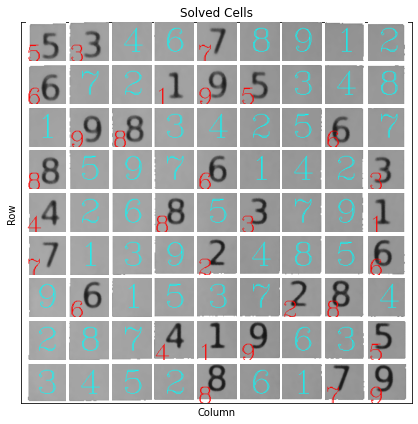

In [21]:
fig = plt.figure(figsize=(7, 7))
plt.title('Solved Cells'); plt.xlabel('Column'); plt.ylabel('Row'); plt.xticks([]); plt.yticks([])
grid = ImageGrid(fig, 111, nrows_ncols=(9, 9), axes_pad=0.05)

for ax, im in zip(grid, solvedCells.reshape(-1, CellH, CellW, 3)):
    ax.imshow(im); ax.axis('off')

plt.show()